In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import pi

# ==========================================
# 1. 全局参数配置 (Global Configuration)
# ==========================================
PARAMS = {
    'N_agents': 25600,        # 微观粒子数 (越大微观曲线越平滑)
    'K1': -0.5,             # 对应 epsilon1
    'K2': 1.0,              # 对应 epsilon2
    'gamma': 0.05,          # 洛伦兹分布宽度
    'omega0': 0.0,          # 中心频率
    'p0': 0.7,              # 初始比例
    'p_s': 0.7,             # 稳态比例
    'r1': 0.1,             # 速率 r_{2->1}
    'dt': 0.01,            # 微观时间步长
    't_max': 200.0,         # 模拟时长
    'seed': 43              # 随机种子
}

# 计算从属参数 r2
PARAMS['r2'] = (PARAMS['p_s'] * PARAMS['r1']) / (1 - PARAMS['p_s'])

# ==========================================
# 2. 通用函数库 (Functions)
# ==========================================
def sample_lorentzian(gamma, size):
    return gamma * np.random.standard_cauchy(size=size)

def get_p_analytic(t, p0, r1, r2):
    """解析解计算 p(t)"""
    sum_r = r1 + r2
    if sum_r == 0: return p0
    p_eq = r2 / sum_r
    return p_eq + (p0 - p_eq) * np.exp(-sum_r * t)

# --- 微观核心算法 ---
def heun_step_thetas(thetas, omegas, Ks, dt):
    Z = np.mean(np.exp(1j * thetas))
    R = np.abs(Z)
    phi = np.angle(Z)
    theta_dot = omegas + Ks * R * np.sin(phi - thetas)
    thetas_pred = thetas + dt * theta_dot
    Z_pred = np.mean(np.exp(1j * thetas_pred))
    R_pred = np.abs(Z_pred)
    phi_pred = np.angle(Z_pred)
    theta_dot_pred = omegas + Ks * R_pred * np.sin(phi_pred - thetas_pred)
    return thetas + dt * 0.5 * (theta_dot + theta_dot_pred)

def chemical_reaction(types, Ks, K1, K2, r1, r2, dt):
    N = len(types)
    n_pos = np.sum(types)
    n_neg = N - n_pos
    # Tau-leaping 泊松步
    n_p2n = np.random.poisson(r1 * n_pos * dt)
    n_n2p = np.random.poisson(r2 * n_neg * dt)
    n_p2n = min(n_p2n, n_pos)
    n_n2p = min(n_n2p, n_neg)
    
    if n_p2n > 0:
        idx = np.random.choice(np.where(types)[0], n_p2n, replace=False)
        types[idx] = False; Ks[idx] = K1
    if n_n2p > 0:
        idx = np.random.choice(np.where(~types)[0], n_n2p, replace=False)
        types[idx] = True; Ks[idx] = K2
    return types, Ks


print("Functions and Parameters defined.")

Functions and Parameters defined.


In [2]:
# ==========================================
# 运行微观模拟 (Microscopic Simulation)
# ==========================================
np.random.seed(PARAMS['seed'])

# 1. 初始化
types = np.random.rand(PARAMS['N_agents']) < PARAMS['p0']
Ks = np.where(types, PARAMS['K2'], PARAMS['K1'])
omegas = sample_lorentzian(PARAMS['gamma'], PARAMS['N_agents']) + PARAMS['omega0']
thetas = 2 * pi * np.random.rand(PARAMS['N_agents'])

# --- 关键：保存初始状态快照，用于宏观方程的初值映射 ---
micro_init_snapshot = {
    'thetas': thetas.copy(),
    'Ks': Ks.copy()
}

# 2. 时间演化
times = np.arange(0, PARAMS['t_max'], PARAMS['dt'])
history = {'t': times, 'R': [], 'R1': [], 'R2': [], 'p': []}

curr_types = types.copy()
curr_Ks = Ks.copy()
curr_thetas = thetas.copy()

print(f"Starting Micro simulation (N={PARAMS['N_agents']})...")

for i, t in enumerate(times):
    # 记录数据
    mask1 = (curr_Ks == PARAMS['K1'])
    mask2 = (curr_Ks == PARAMS['K2'])
    
    Z = np.mean(np.exp(1j * curr_thetas))
    Z1 = np.mean(np.exp(1j * curr_thetas[mask1])) if np.any(mask1) else 0
    Z2 = np.mean(np.exp(1j * curr_thetas[mask2])) if np.any(mask2) else 0
    
    history['R'].append(np.abs(Z))
    history['R1'].append(np.abs(Z1))
    history['R2'].append(np.abs(Z2))
    history['p'].append(np.mean(mask2))
    
    # 演化一步
    if i < len(times) - 1:
        curr_types, curr_Ks = chemical_reaction(curr_types, curr_Ks, 
                                              PARAMS['K1'], PARAMS['K2'], 
                                              PARAMS['r1'], PARAMS['r2'], PARAMS['dt'])
        curr_thetas = heun_step_thetas(curr_thetas, omegas, curr_Ks, PARAMS['dt'])

# 转换为数组方便绘图
micro_data = {k: np.array(v) for k, v in history.items()}
print("Micro simulation finished.")

Starting Micro simulation (N=25600)...
Micro simulation finished.


In [8]:
from math import factorial
# ==========================================
# 3. 运行宏观模拟 (Circular Cumulants Solver)
# ==========================================

def moments_to_cumulants(moments):
    """
    将矩 A_n 转换为圆累积量 kappa_n。
    基于关系: kappa_n = K_n / (n-1)!
    其中 K_n 是标准累积量。
    递归公式推导自生成函数关系:
    A_n = (n-1)! kappa_n + sum_{k=1}^{n-1} [ (n-1)! / (n-k)! ] * A_{n-k} * kappa_k
    """
    N = len(moments)
    kappa = np.zeros(N, dtype=complex)
    
    # moments 数组索引 i 对应 A_{i+1}
    # kappa 数组索引 i 对应 kappa_{i+1}
    
    for n in range(1, N + 1): # n = 1 ... N
        A_n = moments[n-1]
        
        sum_term = 0.0 + 0.0j
        if n > 1:
            # 计算 sum_{k=1}^{n-1}
            fact_n_minus_1 = factorial(n - 1)
            for k in range(1, n):
                # 对应项: kappa_k * A_{n-k} * coefficient
                # kappa_k -> kappa[k-1]
                # A_{n-k} -> moments[n-k-1]
                
                # 系数: (n-1)! / (n-k)!
                coef = fact_n_minus_1 / factorial(n - k)
                
                sum_term += coef * moments[n-k-1] * kappa[k-1]
        
        # kappa_n = (A_n - sum_term) / (n-1)!
        kappa[n-1] = (A_n - sum_term) / factorial(n - 1)
        
    return kappa

def circular_cumulant_ode(t, y, N, p):
    """
    圆累积量层级方程
    y: [kappa1_group1...kappaN_group1, kappa1_group2...kappaN_group2]
    """
    # 1. 恢复质量 m (使用解析解)
    m2 = get_p_analytic(t, p['p0'], p['r1'], p['r2'])
    m = [1.0 - m2, m2]
    
    # 2. 解析状态变量 (kappa)
    K_vec = [y[0:N], y[N:]] 
    
    # 3. 计算场 h_k
    # z^(k) 定义为负一阶矩，即 A_1 的共轭
    # 而 kappa_1 = A_1，所以 z = conj(kappa_1)
    z_ord = [np.conj(K_vec[0][0]), np.conj(K_vec[1][0])]
    Z = m[0] * z_ord[0] + m[1] * z_ord[1]
    
    # h_k = (epsilon/2) * Z
    h = [(p['K1']/2.0)*Z, (p['K2']/2.0)*Z]
    
    # 根据方程定义: B = h_k, C = h_k^*
    B = h
    C = [np.conj(val) for val in h]
    
    # 4. 计算导数
    dKdt = [np.zeros(N, dtype=complex), np.zeros(N, dtype=complex)]
    n_vec = np.arange(1, N + 1)
    
    for k in range(2): # 遍历两个群体
        j = 1 - k      # 另一个群体
        
        # --- A. 计算流动系数 rho_m ---
        # rho_m = (1/m) * sum_{q=1}^m (rho_{m-q} * Delta_kappa_q)
        rho = np.zeros(N + 1, dtype=complex)
        rho[0] = 1.0 + 0j
        
        Delta_K = K_vec[j] - K_vec[k] # 向量化计算差值
        
        for m_idx in range(1, N + 1):
            sum_rho = 0
            for q in range(1, m_idx + 1):
                sum_rho += rho[m_idx - q] * Delta_K[q-1]
            rho[m_idx] = sum_rho / m_idx
            
        # --- B. 计算 d(kappa)/dt ---
        kap = K_vec[k]
        
        # 1. 线性项: -A * m * kappa_m
        # A = i*omega0 + gamma
        A_coef = 1j * p['omega0'] + p['gamma']
        term_linear = -n_vec * A_coef * kap
        
        # 2. 驱动项: + C * delta_{m,1}
        term_driving = np.zeros(N, dtype=complex)
        term_driving[0] = C[k]
        
        # 3. 非线性耦合项: - B * m * ( m * kappa_{m+1} + sum(kappa * kappa) )
        term_nonlinear = np.zeros(N, dtype=complex)
        
        # 为了加速计算，这里对卷积项进行处理
        for m_val in range(1, N + 1):
            idx = m_val - 1
            
            # 部分 1: m * kappa_{m+1} (截断: kappa_{N+1}=0)
            if m_val < N:
                part1 = m_val * kap[m_val] 
            else:
                part1 = 0.0
            
            # 部分 2: sum_{l=1}^m kappa_l * kappa_{m+1-l}
            # 利用切片计算卷积
            # l 从 1 到 m_val
            # kappa_l 对应 kap[0] 到 kap[m_val-1]
            # kappa_{m+1-l} 对应 kap[m_val-1] 到 kap[0] (倒序)
            part2 = np.dot(kap[:m_val], kap[:m_val][::-1])
            
            term_nonlinear[idx] = -B[k] * m_val * (part1 + part2)
            
        # 4. 流动项: D * m * rho_m
        # D = r_{j->k} * (m_j / m_k)
        rate = p['r1'] if k==0 else p['r2']
        ratio = m[j] / m[k] if m[k] > 1e-9 else 0.0
        D_coef = rate * ratio
        
        term_flow = D_coef * n_vec * rho[1:]
        
        dKdt[k] = term_linear + term_driving + term_nonlinear + term_flow
        
    return np.concatenate(dKdt)


# --- 主求解循环 ---
# 定义想要测试的截断阶数
N_orders_to_test = [1, 10] 

macro_results = {}
# 为了得到平滑曲线，这里用了较密的取样点，但计算本身是自适应步长的
t_eval = np.linspace(0, PARAMS['t_max'], 500)

# 从快照恢复初始状态 (微观数据)
init_thetas = micro_init_snapshot['thetas']
init_Ks = micro_init_snapshot['Ks']
mask1 = (init_Ks == PARAMS['K1'])
mask2 = (init_Ks == PARAMS['K2'])
thetas1 = init_thetas[mask1]
thetas2 = init_thetas[mask2]

print(f"Starting Circular Cumulant calculations for N = {N_orders_to_test}...")

for N in N_orders_to_test:
    # 1. 计算微观粒子的初始 *矩* (Moments A_n)
    n_vec = np.arange(1, N + 1)
    
    moments1 = np.array([np.mean(np.exp(1j * n * thetas1)) for n in n_vec]) if len(thetas1)>0 else np.zeros(N, dtype=complex)
    moments2 = np.array([np.mean(np.exp(1j * n * thetas2)) for n in n_vec]) if len(thetas2)>0 else np.zeros(N, dtype=complex)
    
    # 2. 关键转换: 矩 A_n -> 圆累积量 kappa_n
    kappa1_init = moments_to_cumulants(moments1)
    kappa2_init = moments_to_cumulants(moments2)
    
    y0 = np.concatenate([kappa1_init, kappa2_init])
    
    # 3. 求解 ODE
    # 注意: 圆累积量方程通常比矩方程更稳定，但也可能在相变点附近变硬
    sol = solve_ivp(circular_cumulant_ode, (0, PARAMS['t_max']), y0, t_eval=t_eval, 
                    method='BDF', args=(N, PARAMS),
                    rtol=1e-8, atol=1e-10)
    
    if sol.success:
        # 解 sol.y 存储的是 kappa
        kappa1_sol = sol.y[0:N]
        kappa2_sol = sol.y[N:]
        
        # 提取序参量 z = conj(kappa_1) (因为 kappa_1 = A_1)
        z1 = np.conj(kappa1_sol[0])
        z2 = np.conj(kappa2_sol[0])
        
        m2 = get_p_analytic(sol.t, PARAMS['p0'], PARAMS['r1'], PARAMS['r2'])
        m1 = 1.0 - m2
        Z = m1 * z1 + m2 * z2
        
        macro_results[N] = {
            't': sol.t, 'R': np.abs(Z), 
            'R1': np.abs(z1), 'R2': np.abs(z2)
        }
        print(f" -> N={N} Solved (Cumulants).")
    else:
        print(f" -> N={N} Failed: {sol.message}")

print("All Macro runs finished.")

Starting Circular Cumulant calculations for N = [1, 10]...
 -> N=1 Solved (Cumulants).
 -> N=10 Failed: Required step size is less than spacing between numbers.
All Macro runs finished.


KeyError: 2

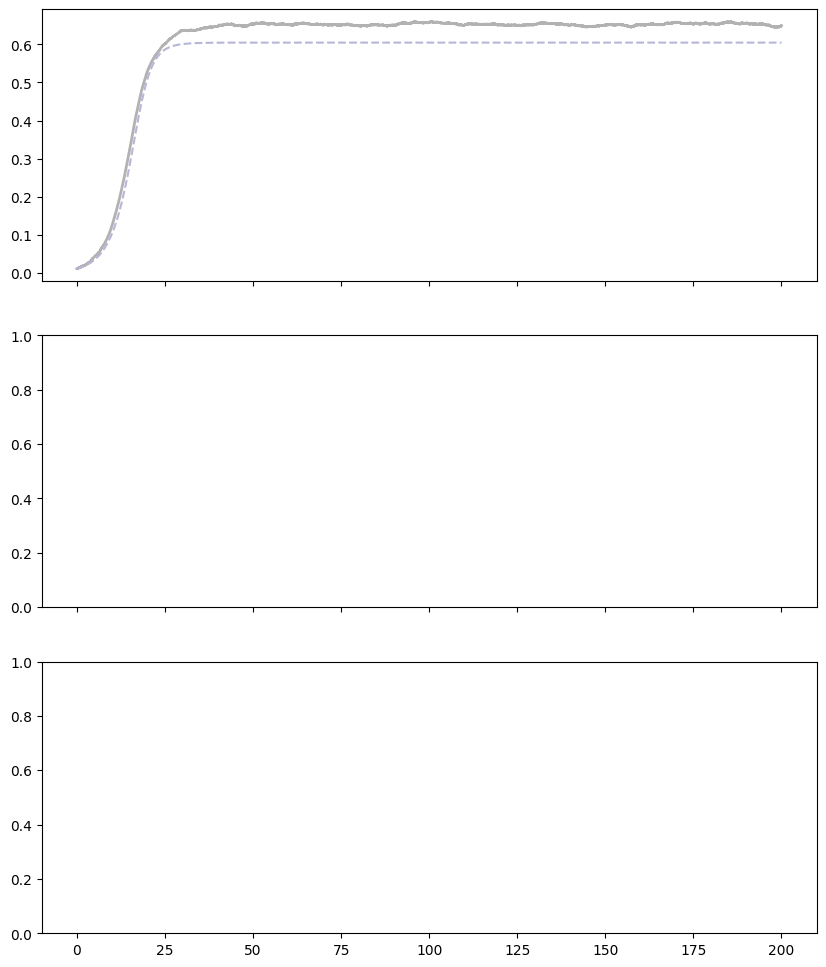

In [5]:
# ==========================================
# 绘图 (Visualization)
# ==========================================
def get_color(idx, total, cmap_name):
    # 获取渐变色：从浅到深 (0.4 -> 1.0)
    cmap = plt.get_cmap(cmap_name)
    return cmap(0.4 + 0.6 * (idx / max(1, total - 1)))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# --- 1. 上图: 总序参量 Z ---
# 微观 (实线)
ax1.plot(micro_data['t'], micro_data['R'], 'k-', alpha=0.3, linewidth=2, label='Micro Sim')

# 宏观 (虚线, 紫色系)
sorted_N = sorted(N_orders_to_test)
for i, N in enumerate(sorted_N):
    res = macro_results[N]
    col = get_color(i, len(sorted_N), 'Purples')
    ax1.plot(res['t'], res['R'], linestyle='--', color=col, 
             linewidth=1.5, label=f'Macro N={N}')

ax1.set_ylabel(r'Total Order $|Z|$')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.01, 1.01)
ax1.set_title(f"Agents={PARAMS['N_agents']}, $K_1$={PARAMS['K1']}, $K_2$={PARAMS['K2']}, γ={PARAMS['gamma']}, $dt$={PARAMS['dt']}, seed={PARAMS['seed']}")

# --- 2. 中图: 子群体序参量 ---
# 微观
ax2.plot(micro_data['t'], micro_data['R1'], color='blue', alpha=0.2, linewidth=2, label='Micro $z^{(1)}<0$')
ax2.plot(micro_data['t'], micro_data['R2'], color='red', alpha=0.2, linewidth=2, label='Micro $z^{(2)}>0$')

# 宏观
for i, N in enumerate(sorted_N):
    res = macro_results[N]
    # 冷色系 -> z1 (K1=-0.5)
    c_z1 = get_color(i, len(sorted_N), 'Blues')
    # 暖色系 -> z2 (K2=1.0)
    c_z2 = get_color(i, len(sorted_N), 'Reds')
    
    # 只给最后一个 N 加图例，避免图例太乱
    lbl_1 = f'Macro $z^{(1)}$ N={N}' if i == len(sorted_N)-1 else None
    lbl_2 = f'Macro $z^{(2)}$ N={N}' if i == len(sorted_N)-1 else None
    
    ax2.plot(res['t'], res['R1'], linestyle='--', color=c_z1, linewidth=1.5, label=lbl_1)
    ax2.plot(res['t'], res['R2'], linestyle='--', color=c_z2, linewidth=1.5, label=lbl_2)

ax2.set_ylabel(r'Sub-Order $|z^{(k)}|$')
ax2.legend(loc='lower right', ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.01, 1.01)
ax2.set_title(f"Truncation Num={sorted_N}")

# --- 3. 下图: 质量 p(t) ---
# 微观
ax3.plot(micro_data['t'], micro_data['p'], 'k-', alpha=0.5, label='Micro $p(t)$')
# 解析 (与 N 无关，只画一条)
t_theory = np.linspace(0, PARAMS['t_max'], 200)
p_theory = get_p_analytic(t_theory, PARAMS['p0'], PARAMS['r1'], PARAMS['r2'])
ax3.plot(t_theory, p_theory, 'r--', linewidth=2, label='Analytic $p(t)$')

ax3.set_ylabel('Proportion $p(t)$')
ax3.set_xlabel('Time')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1.0)
ax3.set_title(f"$p_0$={PARAMS['p0']}, $p_s$={PARAMS['p_s']}, $r_1$={PARAMS['r1']}, $r_2$={PARAMS['r2']:.4f}")

plt.tight_layout()
plt.show()